In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
data=pd.read_csv('data_after_EDA.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AgeOfHouse,YearsSinceRemodel
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,2,2008,WD,Normal,208500,20,20
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,5,2007,WD,Normal,181500,47,47
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,9,2008,WD,Normal,223500,22,21
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,2,2006,WD,Abnorml,140000,108,53
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,12,2008,WD,Normal,250000,23,23


In [4]:
data.shape

(1460, 76)

In [5]:
data.isnull().sum()

Id                   0
MSSubClass           0
MSZoning             0
LotFrontage          0
LotArea              0
                    ..
SaleType             0
SaleCondition        0
SalePrice            0
AgeOfHouse           0
YearsSinceRemodel    0
Length: 76, dtype: int64

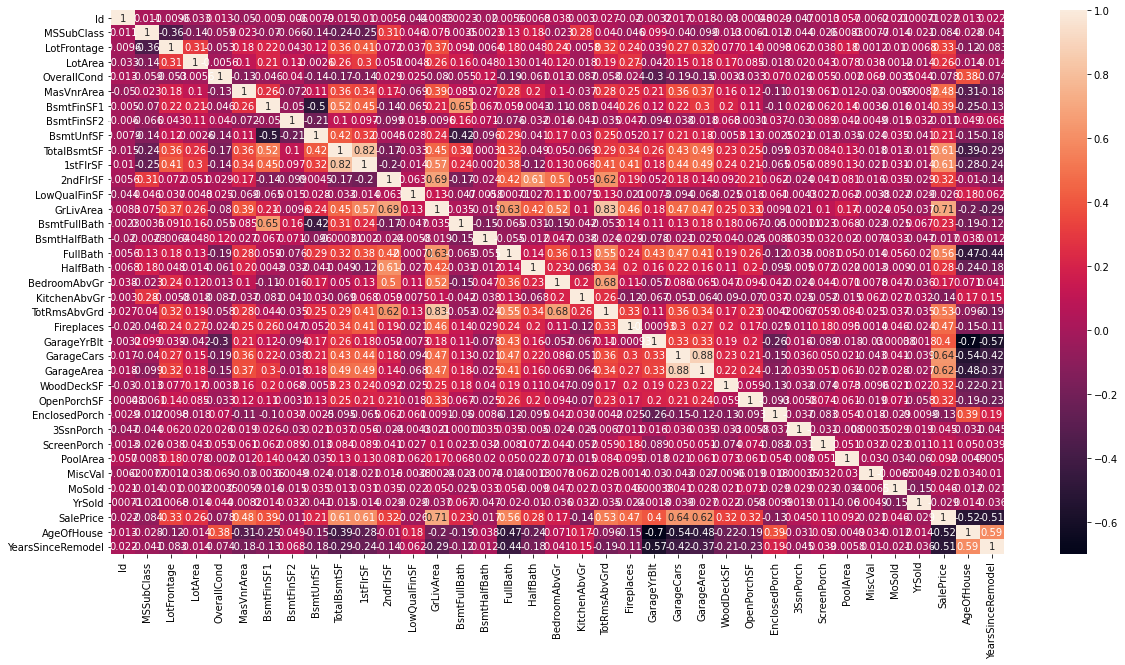

In [6]:
plt.figure(figsize=(20,10))
correlation=data.corr()
sns.heatmap(correlation,annot=True)
plt.show()

In [7]:
def correlated (dataset,thresold):
  corr_column=set()    # all the highly corelated column
  for i in range(len(correlation.columns)):
      for j in range(i):
        if abs(correlation.iloc[i,j])>=thresold:  # we want absolute value
          column_name=correlation.columns[i]      # getting the name of columns
          corr_column.add(column_name)            # add he name column in empty set
  return corr_column          

In [8]:
# Calling the function with threshold value 0.80
highly_correlated_features=correlated(data,0.80)
print('total highly correlated features:',len(set(highly_correlated_features)))

total highly correlated features: 3


In [9]:
highly_correlated_features

{'1stFlrSF', 'GarageArea', 'TotRmsAbvGrd'}

Getting rid of unnecessary variables like 'Id' and highly correlated features as well beacuse they can affect the model building process

In [10]:
data.drop(['Id'],axis=1,inplace=True)

In [11]:
data.drop(['1stFlrSF'],axis=1,inplace=True)

In [12]:
data.drop(['GarageArea'],axis=1,inplace=True)

In [13]:
data.drop(['TotRmsAbvGrd'],axis=1,inplace=True)

In [14]:
features=['TotalBsmtSF','GrLivArea','MasVnrArea','GarageYrBlt','AgeOfHouse','YearsSinceRemodel','MSSubClass','Neighborhood',
          'ExterQual','OverallQual','Foundation','MasVnrType','Exterior1st','Exterior2nd','BsmtQual','BsmtFinType1','HeatingQC',
          'GarageFinish','GarageType','KitchenQual']

In [15]:
final_df=data[features]
final_df.shape

(1460, 20)

In [16]:
final_df.head()

,TotalBsmtSF,GrLivArea,MasVnrArea,GarageYrBlt,AgeOfHouse,YearsSinceRemodel,MSSubClass,Neighborhood,ExterQual,OverallQual,Foundation,MasVnrType,Exterior1st,Exterior2nd,BsmtQual,BsmtFinType1,HeatingQC,GarageFinish,GarageType,KitchenQual
0,856,1710,196.0,2003.0,20,20,60,CollgCr,Gd,Medium,PConc,BrkFace,VinylSd,VinylSd,Gd,GLQ,Ex,RFn,Attchd,Gd
1,1262,1262,0.0,1976.0,47,47,20,Veenker,TA,Medium,CBlock,None,MetalSd,MetalSd,Gd,ALQ,Ex,RFn,Attchd,TA
2,920,1786,162.0,2001.0,22,21,60,CollgCr,Gd,Medium,PConc,BrkFace,VinylSd,VinylSd,Gd,GLQ,Ex,RFn,Attchd,Gd
3,756,1717,0.0,1998.0,108,53,70,Crawfor,TA,Medium,BrkTil,None,Wd Sdng,Wd Shng,TA,ALQ,Gd,Unf,Detchd,Gd
4,1145,2198,350.0,2000.0,23,23,60,NoRidge,Gd,High,PConc,BrkFace,VinylSd,VinylSd,Gd,GLQ,Ex,RFn,Attchd,Gd


In [17]:
final_df.shape

(1460, 20)

Label Encoding of ordinal categorical variables, so that they don't loose their ordinal characteristics during model building process

In [18]:
category_variables = list(final_df.dtypes[data.dtypes == 'object'].index)

In [19]:
category_variables

['Neighborhood',
 'ExterQual',
 'OverallQual',
 'Foundation',
 'MasVnrType',
 'Exterior1st',
 'Exterior2nd',
 'BsmtQual',
 'BsmtFinType1',
 'HeatingQC',
 'GarageFinish',
 'GarageType',
 'KitchenQual']

ExterQual feature represents the quality of the exterior material. It has categories like 'Ex' (Excellent), 'Gd' (Good), 'TA' (Average/Typical), 'Fa' (Fair), and 'Po' (Poor). These categories have a clear ordering in terms of quality, so it can be considered an ordinal variable.

In [20]:
# Define the mapping dictionary for ExterQual
ExterQual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Perform ordinal encoding for ExterQual
final_df['ExterQual'] = final_df['ExterQual'].map(ExterQual_mapping)

In [21]:
# Define the mapping dictionary for OverallQual
OverallQual_mapping = {'High': 3, 'Medium': 2, 'Low': 1}

# Perform ordinal encoding for OverallQual
final_df['OverallQual'] = final_df['OverallQual'].map(OverallQual_mapping)


In [22]:
# Define the mapping dictionary for BsmtQual
BsmtQual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Perform ordinal encoding for BsmtQual
final_df['BsmtQual'] = final_df['BsmtQual'].map(BsmtQual_mapping)

In [23]:
# Define the mapping dictionary for HeatingQC
HeatingQC_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Perform ordinal encoding for HeatingQC
final_df['HeatingQC'] = final_df['HeatingQC'].map(HeatingQC_mapping)


In [24]:
# Define the mapping dictionary for GarageFinish
GarageFinish_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1}

# Perform ordinal encoding for GarageFinish
final_df['GarageFinish'] = final_df['GarageFinish'].map(GarageFinish_mapping)


In [25]:
# Define the mapping dictionary for KitchenQual
KitchenQual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Perform ordinal encoding for KitchenQual
final_df['KitchenQual'] = final_df['KitchenQual'].map(KitchenQual_mapping)

In [26]:
final_df.dtypes

TotalBsmtSF            int64
GrLivArea              int64
MasVnrArea           float64
GarageYrBlt          float64
AgeOfHouse             int64
YearsSinceRemodel      int64
MSSubClass             int64
Neighborhood          object
ExterQual              int64
OverallQual            int64
Foundation            object
MasVnrType            object
Exterior1st           object
Exterior2nd           object
BsmtQual               int64
BsmtFinType1          object
HeatingQC              int64
GarageFinish           int64
GarageType            object
KitchenQual            int64
dtype: object

In [27]:
category_variables = final_df.select_dtypes(include=['object']).columns

In [28]:
category_variables

Index(['Neighborhood', 'Foundation', 'MasVnrType', 'Exterior1st',
       'Exterior2nd', 'BsmtFinType1', 'GarageType'],
      dtype='object')

In [29]:
print(final_df.shape)
final_df.head()

(1460, 20)


,TotalBsmtSF,GrLivArea,MasVnrArea,GarageYrBlt,AgeOfHouse,YearsSinceRemodel,MSSubClass,Neighborhood,ExterQual,OverallQual,Foundation,MasVnrType,Exterior1st,Exterior2nd,BsmtQual,BsmtFinType1,HeatingQC,GarageFinish,GarageType,KitchenQual
0,856,1710,196.0,2003.0,20,20,60,CollgCr,4,2,PConc,BrkFace,VinylSd,VinylSd,4,GLQ,5,2,Attchd,4
1,1262,1262,0.0,1976.0,47,47,20,Veenker,3,2,CBlock,None,MetalSd,MetalSd,4,ALQ,5,2,Attchd,3
2,920,1786,162.0,2001.0,22,21,60,CollgCr,4,2,PConc,BrkFace,VinylSd,VinylSd,4,GLQ,5,2,Attchd,4
3,756,1717,0.0,1998.0,108,53,70,Crawfor,3,2,BrkTil,None,Wd Sdng,Wd Shng,3,ALQ,4,1,Detchd,4
4,1145,2198,350.0,2000.0,23,23,60,NoRidge,4,3,PConc,BrkFace,VinylSd,VinylSd,4,GLQ,5,2,Attchd,4


One hot enconding for the rest of the categorical features

In [30]:
#add dummy variable to convert textual data to numerical data through one hot encoding
final_df=pd.get_dummies(final_df,columns=category_variables,drop_first=True)

In [31]:
final_df.head()

,TotalBsmtSF,GrLivArea,MasVnrArea,GarageYrBlt,AgeOfHouse,YearsSinceRemodel,MSSubClass,ExterQual,OverallQual,BsmtQual,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,856,1710,196.0,2003.0,20,20,60,4,2,4,...,0,1,0,0,0,1,0,0,0,0
1,1262,1262,0.0,1976.0,47,47,20,3,2,4,...,0,0,0,0,0,1,0,0,0,0
2,920,1786,162.0,2001.0,22,21,60,4,2,4,...,0,1,0,0,0,1,0,0,0,0
3,756,1717,0.0,1998.0,108,53,70,3,2,3,...,0,0,0,0,0,0,0,0,0,1
4,1145,2198,350.0,2000.0,23,23,60,4,3,4,...,0,1,0,0,0,1,0,0,0,0


In [32]:
final_df.columns

Index(['TotalBsmtSF', 'GrLivArea', 'MasVnrArea', 'GarageYrBlt', 'AgeOfHouse',
       'YearsSinceRemodel', 'MSSubClass', 'ExterQual', 'OverallQual',
       'BsmtQual', 'HeatingQC', 'GarageFinish', 'KitchenQual',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'Foundation_Wood', 'MasVnrType_BrkFace',
       'MasVnrType_None', 'MasV

In [33]:
x=final_df
y=data["SalePrice"]

In [34]:
x.head()

,TotalBsmtSF,GrLivArea,MasVnrArea,GarageYrBlt,AgeOfHouse,YearsSinceRemodel,MSSubClass,ExterQual,OverallQual,BsmtQual,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,856,1710,196.0,2003.0,20,20,60,4,2,4,...,0,1,0,0,0,1,0,0,0,0
1,1262,1262,0.0,1976.0,47,47,20,3,2,4,...,0,0,0,0,0,1,0,0,0,0
2,920,1786,162.0,2001.0,22,21,60,4,2,4,...,0,1,0,0,0,1,0,0,0,0
3,756,1717,0.0,1998.0,108,53,70,3,2,3,...,0,0,0,0,0,0,0,0,0,1
4,1145,2198,350.0,2000.0,23,23,60,4,3,4,...,0,1,0,0,0,1,0,0,0,0


Now that all the necessary steps for model buuilding is completed we can start with the Model Building

# Model Building

## Ridge Regression

Root Mean Squared Logarithmic Error (RMSLE): 0.03094955420043953
R2 Score: 0.8663498643891977
Adjusted R2 Score: 0.8533561012048141


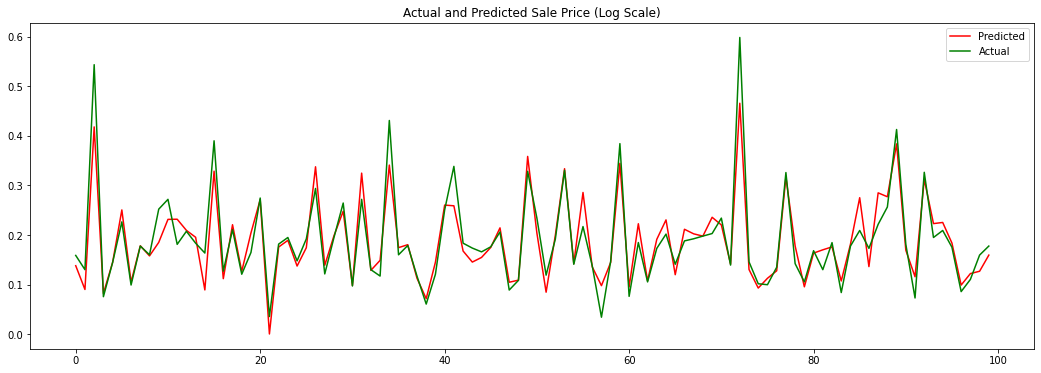

In [35]:
def evaluation_metrics(x_train, y_train, y_predicted):
    # Handle potential NaN values in y_predicted or y_train
    y_predicted = np.nan_to_num(y_predicted)
    y_train = np.nan_to_num(y_train)
    
    # Calculate RMSLE
    squared_log_errors = (np.log1p(y_predicted) - np.log1p(y_train))**2
    mean_squared_log_error_val = np.mean(squared_log_errors)
    root_mean_squared_log_error = math.sqrt(mean_squared_log_error_val)
    
    r2_score_val = r2_score(y_train, y_predicted)
    adjusted_r2_score = 1 - ((1 - r2_score_val) * (x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1))

    print("Root Mean Squared Logarithmic Error (RMSLE):", root_mean_squared_log_error)
    print("R2 Score:", r2_score_val)
    print("Adjusted R2 Score:", adjusted_r2_score)
    
    # Plotting Actual and Predicted Values
    plt.figure(figsize=(18, 6))
    plt.plot(np.log1p(y_predicted)[:100], color='red')
    plt.plot(np.log1p(np.array(y_train)[:100]), color='green')
    plt.legend(["Predicted", "Actual"])
    plt.title('Actual and Predicted Sale Price (Log Scale)')



# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the independent features
X_scaled = scaler.fit_transform(x)

# Reshape the target variable
y_reshaped = np.array(y).reshape(-1, 1)

# Scale the target variable
y_scaled = scaler.fit_transform(y_reshaped)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.35, random_state=101)

from sklearn.linear_model import Ridge

# Create a Ridge regression object
ridge = Ridge(alpha=0.5)  # You can adjust the alpha parameter for regularization strength

# Fit the model to the training data
ridge.fit(x_train, y_train)

# Make predictions
y_pred_train = ridge.predict(x_train)
y_pred_test = ridge.predict(x_test)

# Evaluate the model
evaluation_metrics(x_train, y_train, y_pred_train)


Root Mean Squared Logarithmic Error (RMSLE): 0.037812011729783684
R2 Score: 0.7666675938901037
Adjusted R2 Score: 0.7206583870515326


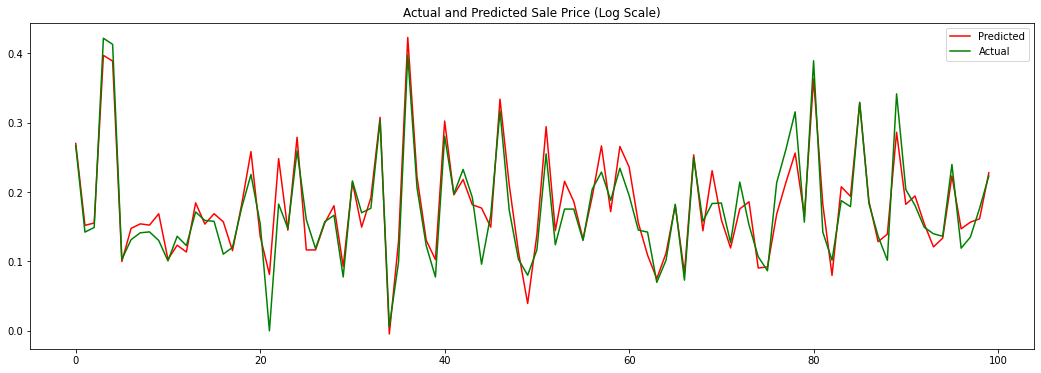

In [36]:
# evaluation metrics for test data set
evaluation_metrics(x_test,y_test,y_pred_test)

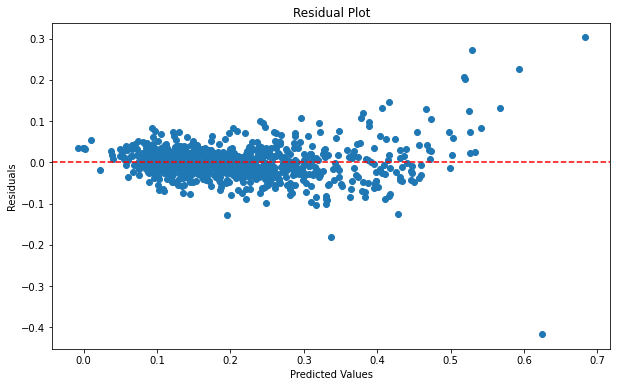

In [37]:
# Calculate the residuals
residuals = y_train - y_pred_train

# Create a scatter plot of residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The scatter plot of the residuals as shown above don't show any pattern in particular, so its safe to say that it indicates homoscedasticity as homoscedastic pattern would show a random scatter of points around the horizontal line at y=0, without any clear funnel-shaped widening or narrowing spread.

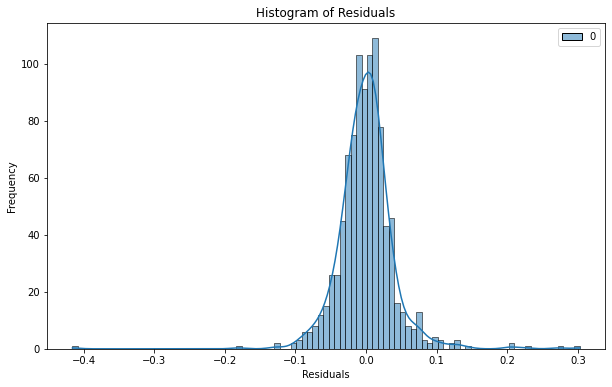

In [38]:
# Create a histogram of the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

As the histfogram of the residuals resembles a bell shaped curve, we can say that the residuals are normally distributed.
And thus we can say that there are no issues with the assumptions for our model.

However there some outliers as the plot is a little skewed from both sides as well

<Figure size 720x432 with 0 Axes>

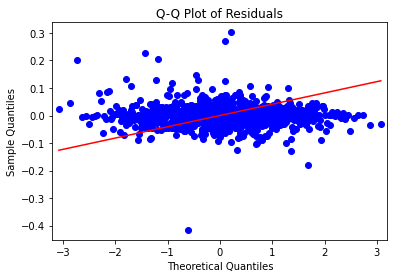

In [39]:
import statsmodels.api as sm
# Create a Q-Q plot of the residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.show()

In the above plot the scatterplots form a straight line parallel to the x-axis, which means that the residuals are roughly linearly related to the theoretical quantiles. 

The red line, being a little deviated, suggests that the residuals do not perfectly follow a normal distribution. 

There might be some skewness or kurtosis present in the residuals, causing the deviation from normality, whcih can seen in the histogram as well

## Stacked Model (Linear Regression, Ridge Regression and Deicision Tree

In [40]:
# Define base models
base_models = [
    ('linear_regression', LinearRegression()),
    ('ridge_regression', Ridge(alpha=0.5)),
    ('decision_tree', DecisionTreeRegressor())
]

# Initialize the stacking regressor with the base models and the meta-model
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Train the stacking regressor
stacking_regressor.fit(x_train, y_train)

# Make predictions using the stacking regressor
y_pred_train_stacked = stacking_regressor.predict(x_train)
y_pred_test_stacked = stacking_regressor.predict(x_test)

Training Set:
Root Mean Squared Logarithmic Error (RMSLE): 0.11988101474022965
R2 Score: 0.882901946626094
Adjusted R2 Score: 0.8715174136591864


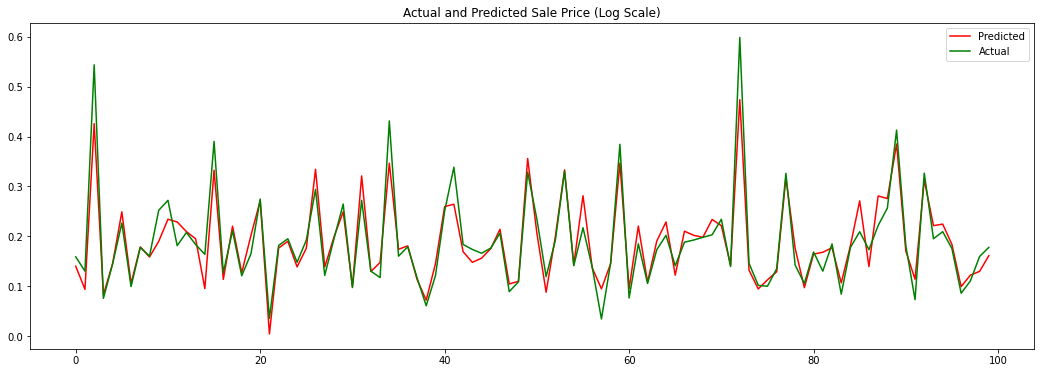

In [41]:
# Evaluate the performance of the stacking regressor
print("Training Set:")
evaluation_metrics(x_train, y_train, y_pred_train_stacked)


Test Set:
Root Mean Squared Logarithmic Error (RMSLE): 0.1147519618405957
R2 Score: 0.7803913495168713
Adjusted R2 Score: 0.7370882353370994


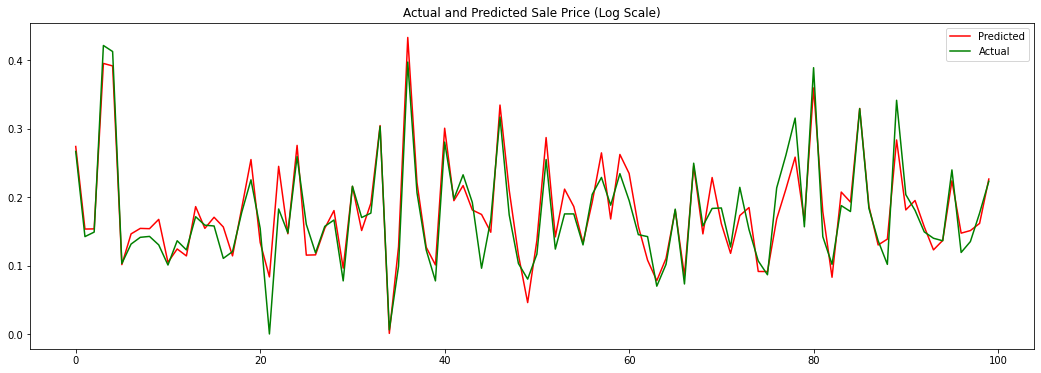

In [42]:
print("\nTest Set:")
evaluation_metrics(x_test, y_test, y_pred_test_stacked)

## Random Forest 

In [43]:
RFR=RandomForestRegressor()

In [44]:
# number of trees in random forest
n_estimators=[10,15]
#number of feature to consider at every split
max_features=[0.6]
# maximum number of level in trees
max_depth=[4,6,8,10] 

# Hyperparameter Grid
param_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            }
print(param_grid)


{'n_estimators': [10, 15], 'max_features': [0.6], 'max_depth': [4, 6, 8, 10]}


In [45]:
RF_grid=GridSearchCV(estimator=RFR,param_grid=param_grid,cv=5,verbose=2)

In [46]:
RF_grid.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....max_depth=4, max_features=0.6, n_estimators=10; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=10; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=10; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=10; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=10; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=15; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=15; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=15; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=15; total time=   0.0s
[CV] END .....max_depth=4, max_features=0.6, n_estimators=15; total time=   0.0s
[CV] END .....max_depth=6, max_features=0.6, n_estimators=10; total time=   0.0s
[CV] END .....max_depth=6, max_features=0.6, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10], 'max_features': [0.6],
                         'n_estimators': [10, 15]},
             verbose=2)

In [47]:
RF_grid.best_params_

{'max_depth': 10, 'max_features': 0.6, 'n_estimators': 15}

In [48]:
RF_grid.best_score_

0.8085023203822775

In [49]:
Random_Forest_optimal_model =RF_grid.best_estimator_
y_predict_train_Random_Forest=Random_Forest_optimal_model.predict(x_train)
y_predict_test_Random_Forest=Random_Forest_optimal_model.predict(x_test)

Root Mean Squared Logarithmic Error (RMSLE): 0.11913447091666998
R2 Score: 0.9584460897422843
Adjusted R2 Score: 0.9544061262450063


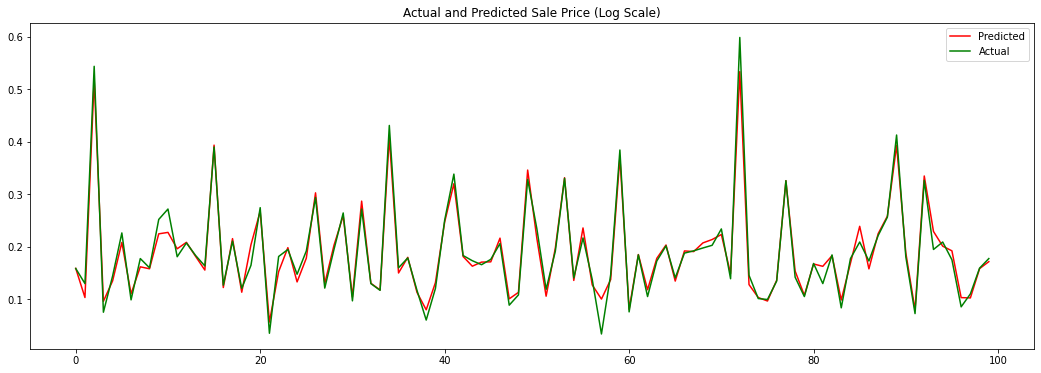

In [50]:
# evaluation metrics for train data set
evaluation_metrics(x_train,y_train,y_predict_train_Random_Forest)

Root Mean Squared Logarithmic Error (RMSLE): 0.1121066689310742
R2 Score: 0.8189311646989955
Adjusted R2 Score: 0.7832274506959805


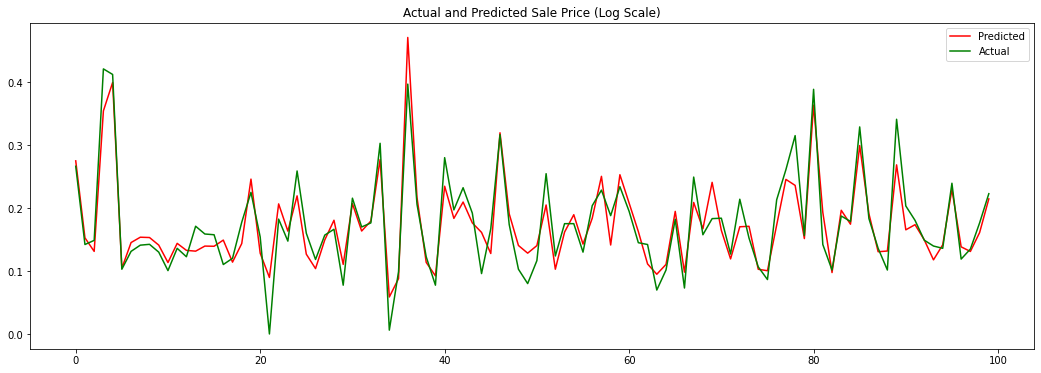

In [51]:
# evaluation metrics for test data set
evaluation_metrics(x_test,y_test,y_predict_test_Random_Forest)

## XGBOOST

In [52]:
# Number of trees
total_estimators = [10,20]

# Maximum depth of trees
max_depth_of_trees = [2,4,6]

# Hyperparameter Grid
param_xgboost = {'total_estimators' : total_estimators,
              'max_depth' : max_depth_of_trees
              }
     

In [53]:
# Instantiate  XGBRegressor
import xgboost as xgb
xgboost_model = xgb.XGBRegressor()

# Grid search
xgboost_grid = GridSearchCV(estimator=xgboost_model,param_grid = param_xgboost,cv = 3, verbose=2,scoring="r2")

xgboost_grid.fit(x_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[13:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "total_estimators" } are not used.

[CV] END ...................max_depth=2, total_estimators=10; total time=   0.0s
[13:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "total_estimators" } are not used.

[CV] END ...................max_depth=2, total_estimators=10; total time=   0.0s
[13:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "total_estimators" } are not used.

[CV] END ...................max_depth=2, total_estimators=10; total time=   0.0s
[13:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [2, 4, 6], 'total_estimators': [10, 20]},
             scoring='r2', verbose=2)

In [54]:
xgboost_grid.best_score_

0.7918905552116932

In [55]:
xgboost_grid.best_params_

{'max_depth': 2, 'total_estimators': 10}

In [56]:
xgboost_optimal_model =xgboost_grid.best_estimator_

In [57]:
y_pred_xgboost_test=xgboost_optimal_model.predict(x_test)
y_pred_xgboost_train=xgboost_optimal_model.predict(x_train)

Root Mean Squared Logarithmic Error (RMSLE): 0.12115301633183104
R2 Score: 0.9526861866492546
Adjusted R2 Score: 0.9480862325734878


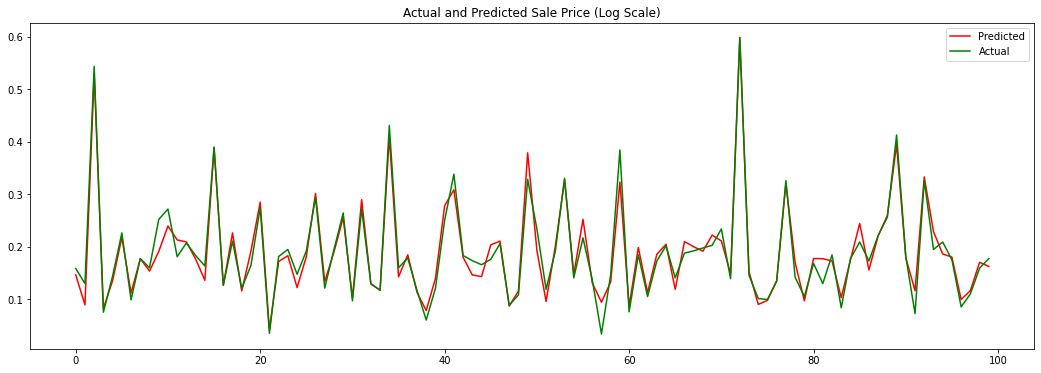

In [58]:
#Evaluation metrics for Train set
evaluation_metrics(x_train,y_train,y_pred_xgboost_train)

Root Mean Squared Logarithmic Error (RMSLE): 0.11407801908785936
R2 Score: 0.8669788872704327
Adjusted R2 Score: 0.8407493720843209


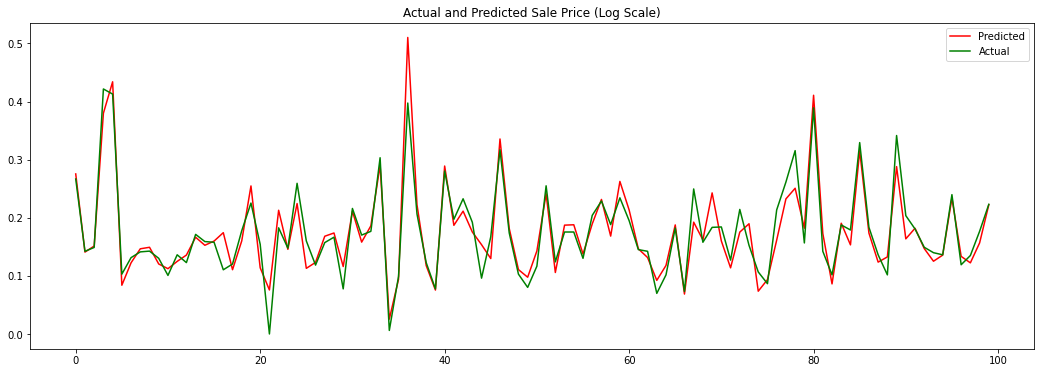

In [59]:
# Evaluation metrics for Test set
evaluation_metrics(x_test,y_test,y_pred_xgboost_test) 

In [60]:
importance=xgboost_optimal_model.feature_importances_
importance

array([0.02733885, 0.04099327, 0.00335421, 0.01119512, 0.01412354,
       0.00394408, 0.00683212, 0.16789745, 0.26206654, 0.21444055,
       0.01084263, 0.03682886, 0.11128309, 0.        , 0.        ,
       0.00300592, 0.00383142, 0.        , 0.00519714, 0.00823345,
       0.        , 0.        , 0.00174492, 0.00107771, 0.00252939,
       0.        , 0.        , 0.00134023, 0.00134221, 0.        ,
       0.        , 0.        , 0.        , 0.00251744, 0.00194552,
       0.        , 0.00250482, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00511708,
       0.        , 0.00150483, 0.00204167, 0.        , 0.        ,
       0.00082743, 0.        , 0.        , 0.00081126, 0.        ,
       0.        , 0.        , 0.00219682, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00123174, 0.        ,
       0.00179826, 0.        , 0.00206444, 0.        , 0.     

In [61]:
imp_dict = {'Feature' : list(x.columns),
                   'Feature Importance' : importance}

importance_df = pd.DataFrame(imp_dict)

In [62]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
8,OverallQual,0.262067
9,BsmtQual,0.214441
7,ExterQual,0.167897
12,KitchenQual,0.111283
1,GrLivArea,0.040993
...,...,...
49,Exterior1st_CemntBd,0.000000
51,Exterior1st_ImStucc,0.000000
52,Exterior1st_MetalSd,0.000000
54,Exterior1st_Stone,0.000000


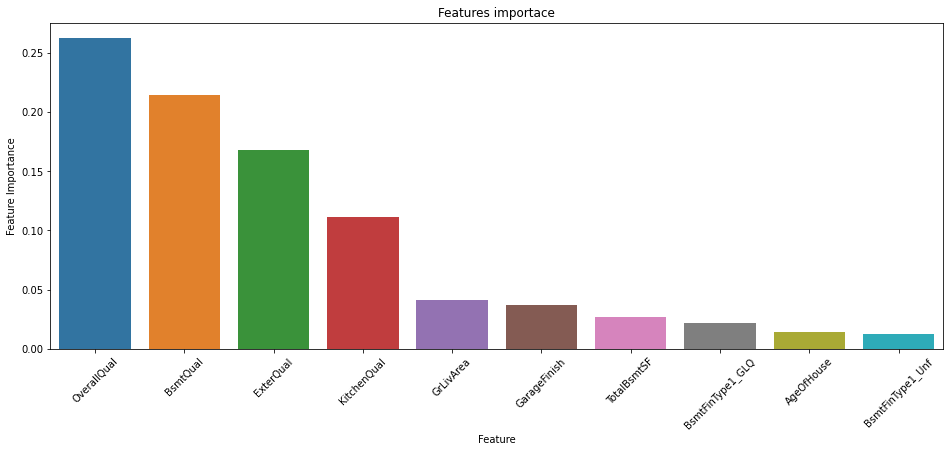

In [63]:
# Feature importance plot
plt.figure(figsize=(16,6))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])
plt.xticks(rotation=45)
plt.show()
     

In [67]:
# list of all evaluation matrics values
score_values=[[0.037812011729783684, 0.7666675938901037 ,0.7206583870515326],
              [0.1147519618405957 ,0.7803913495168713 ,0.7370882353370994],
              [0.1121066689310742 , 0.8189311646989955,0.7832274506959805],
              [ 0.11407801908785936 ,0.8669788872704327  ,0.8407493720843209]]
# Create the pandas DataFrame
df_score = pd.DataFrame(score_values,columns=['RMSLE', 'R2', 'AdjustedR2'], index=['Ridge Regression', 'Stacked Model', 'Random Forest', 'Xgboost'])
df_score

,RMSLE,R2,AdjustedR2
Ridge Regression,0.037812,0.766668,0.720658
Stacked Model,0.114752,0.780391,0.737088
Random Forest,0.112107,0.818931,0.783227
Xgboost,0.114078,0.866979,0.840749


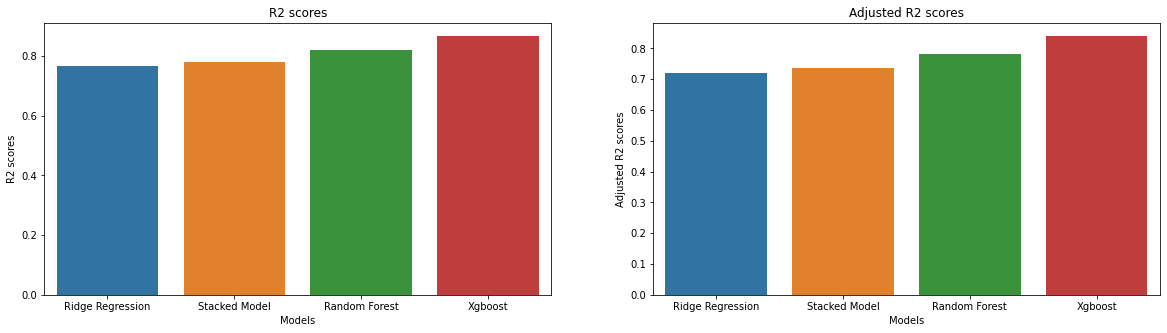

In [68]:
#bar plot for R2 score
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 5))
x_= ['Ridge Regression', 'Stacked Model', 'Random Forest', 'Xgboost']
ax1.set_title('R2 scores')
ax = sns.barplot(x = x_, y='R2', data =df_score , ax = ax1)
ax.set_xlabel('Models')
ax.set_ylabel('R2 scores')

# barplot for adjustedR2 
ax = sns.barplot(x = x_, y='AdjustedR2',  data = df_score, ax = ax2)
ax2.set_title('Adjusted R2 scores')
ax.set_xlabel('Models')
ax.set_ylabel('Adjusted R2 scores')
plt.show()

### From the above plot it is clear that the XGBoost model shows the highest R-squared and Adjusted R-squared error

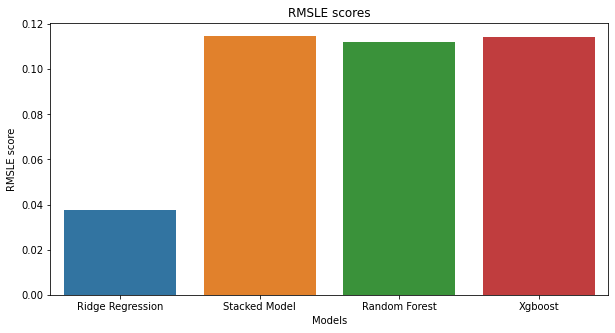

In [69]:
#barplot of RMSLE score
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 5))
x_= ['Ridge Regression', 'Stacked Model', 'Random Forest', 'Xgboost']
ax1.set_title('RMSLE scores')
ax = sns.barplot(x = x_, y='RMSLE', data =df_score , ax = ax1)
ax.set_xlabel('Models')
ax.set_ylabel('RMSLE score');


### In terms of RMSLE metrics Ridge Regression is giving better results as compared to other models